## Linear regression 

Goals:
* Understand the interpretation of parameters in a simple linear regression model (intercept and covariate)
* Understand what mean centering a regressor does and doesn't do
* Understand parameter interpretation in multiple linear regression
    - Two groups with a covariate
    - Two covariates
* Introduction to orthogonalization
    - Note, it is hardly ever necessary and leads to more problems that it aims to solve

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

### Simple linear regression

Start by making up some data relating age to wisdom and then run a simple linear regression.  Some of the variables that are created will not be used until later on.

Please note the series of regression models here are for illustrating different behavior in regression models and this is not a recommended "strategy" for model selection.  Generally you should have a model that aligns with the theory you're testing and you'd run that model and be done.  Otherwise it is p-hacky.

In [2]:
np.random.seed(1820) # Florence Nightingale, of Nightingale diagrams, was born this year.  
                     # Nurse/statistician saving lives during war with statistics.
nsubs  = 100
age = np.random.normal(loc=50, scale=10, size=nsubs)
does_puzzles = age + np.random.normal(scale = 10, size=nsubs)
does_puzzles = 1 * (does_puzzles > np.median(does_puzzles))
avg_sleep_per_night = 8 + (age - 50)/10 + np.random.normal(loc=0, scale=2, size=nsubs)


wisdom = 20 + .2 * age + .2*avg_sleep_per_night + np.random.normal(scale=8, size=nsubs)

Run the simple model to see if wisdom is related to age (I try to avoid using the word "predictors" to avoid the impression that this is a model that tells us about the ability of age to predict wisdom).
$$wisdom = \beta_0 + \beta_1 age + \epsilon$$

In [3]:
x_int_age = pd.DataFrame({'intercept': np.ones(nsubs),
                           'age': age})

mod_int_age = sm.OLS(wisdom, x_int_age).fit()
print(mod_int_age.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.087
No. Observations:                 100   F-statistic:                     10.40
Covariance Type:            nonrobust   Prob (F-statistic):            0.00172
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.3997      4.036      4.806      0.000      11.390      27.409
age            0.2555      0.079      3.224      0.002       0.098       0.413

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


The `age` effect is the rate of change in wisdom as one ages.  Specifically, the average wisdom increases for somebody who is 1 year older than another person by .2555 wisdom units.  The `intercept` term is *always* the value of the dependent variable when all regressors are set to 0; in this case it is how wise a 0 year old is.  Here is a plot of the model fit and data.

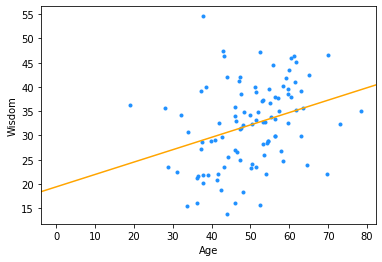

In [4]:
plt.plot(age, wisdom, '.', color='dodgerblue')
plt.axline(xy1=(0, mod_int_age.params['intercept']),
           slope=mod_int_age.params['age'], color='orange')
plt.xlabel('Age')
plt.ylabel('Wisdom')
plt.show()


### Mean centering a regressor

Mean centering is the simplest and most acceptable form of orthogonalization.  Mean centering simply means calculating the mean of a regressor and subtracting it from the regressor values to make a new regressor.  The age centered model is:
$$wisdom = \beta_0 + \beta_1 \times age\_mean\_centered + \epsilon$$
and the age slope will *not* change, but the intercept will change.  This is the biggest confusion about centering regressors and orthogonalization - the parameter estimate for the regressor that was changed doesn't change, but all other regressors will likely change and have new interpretations.  In this case the intercept's interpretation is "wisdom when `age_mean_centered` is 0" which is "wisdom when age is the mean age".  That's actually a much nicer interpretation!

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.087
No. Observations:                 100   F-statistic:                     10.40
Covariance Type:            nonrobust   Prob (F-statistic):            0.00172
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       32.1404      0.822     39.124      0.000      30.510      33.771
age_centered     0.2555      0.079      3.224      0.002       0.098       0.413

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


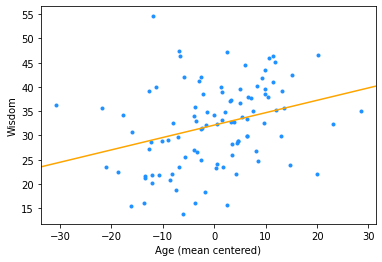

In [5]:
x_int_age_centered = pd.DataFrame({'intercept': np.ones(nsubs),
                                   'age_centered': age - np.mean(age)})

mod_int_age_centered = sm.OLS(wisdom, x_int_age_centered).fit()
print(mod_int_age_centered.summary(slim=True))

plt.plot(x_int_age_centered['age_centered'], wisdom, '.', color='dodgerblue')
plt.axline(xy1=(0, mod_int_age_centered.params['intercept']),
           slope=mod_int_age_centered.params['age_centered'], color='orange')
plt.xlabel('Age (mean centered)')
plt.ylabel('Wisdom')
plt.show()


In summary, mean centering a regressor will not change anything about the parameter estimate for that regressor, but it will change the interpretation of all other parameters in the model.  It is the most acceptable form of orthogonalization, although it can still be applied in ways that are detrimental to the analysis and interpretation, which will be discussed in the orthogonalization section.

### Adding more regressors to the model: Two groups and a covariate

Adding one more level of complexity to the previous model by adding a group covariate, whether or not a person does puzzles.  Note, the series of models presented here isn't meant to illustrate some type of "model selection" process, but is simply a series of models to illustrate different regression settings and how parameters are interpreted.  In real life running a large series of models should only be done in exploratory analyses as it is basically p-hacking.

As shown in the last module that covered 2-sample t-tests, ``does_puzzles`` can be modeled in many different ways. Here the ``does_puzzles`` indicator (1 = does puzzles and 0 = does not do puzzles) and an intercept will be used, along with age:
$$wisdom = \beta_0 + \beta_1 does\_puzzles + \beta_2 age + \epsilon.$$

No need to center anything here and parameter interpretations are:
*  $\beta_0$: The mean wisdom for those who do not do puzzles and is 0 years old.
*  $\beta_1$: The average difference in wisdom between those who do and do not do puzzles, adjusted for age (i.e., for age = 0)
*  $\beta_2$: Age effect, adjusted for whether or not a person does puzzles (Age slope when different intercepts for groups are allowed)

What does "adjusted for age" mean?  If age isn't in the model, the puzzle group comparison in wisdom will correspond to the average age of the does and does not do puzzle groups, respectively.  We already know there is an age effect from the last model, so if the puzzle doers are older and age is ignored, the puzzle doers may have a higher wisdom score, unadjusted for age, than the folks who don't do puzzles.  By adding age to the model, the comparison now compares the groups when they are the same age.  Since the model represents two parallel lines (one for each group) the group comparison is the same for all ages, so comparing groups when age=0 is identical to the comparison when age = mean(age).

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.085
No. Observations:                 100   F-statistic:                     5.591
Covariance Type:            nonrobust   Prob (F-statistic):            0.00504
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       17.5530      4.533      3.872      0.000       8.556      26.550
does_puzzles    -1.8770      2.090     -0.898      0.371      -6.024       2.271
age              0.3113      0.101      3.089      0.003       0.111       0.511

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


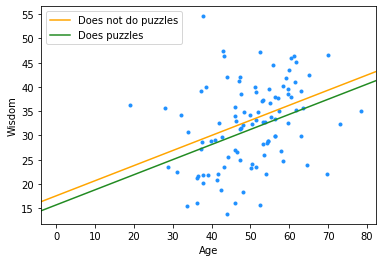

In [6]:
x_int_puzzles_age = pd.DataFrame({'intercept': np.ones(nsubs),
                                   'does_puzzles': does_puzzles,
                                   'age': age})

mod_int_puzzles_age = sm.OLS(wisdom, x_int_puzzles_age).fit()
print(mod_int_puzzles_age.summary(slim=True))

plt.plot(age, wisdom, '.', color='dodgerblue')
plt.axline(xy1=(0, mod_int_puzzles_age.params['intercept']),
           slope=mod_int_puzzles_age.params['age'], color='orange',
           label='Does not do puzzles')
plt.axline(xy1=(0, mod_int_puzzles_age.params['intercept'] + mod_int_puzzles_age.params['does_puzzles']),
           slope=mod_int_puzzles_age.params['age'], color='forestgreen',
           label='Does puzzles')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Wisdom')
plt.savefig("/Users/jeanettemumford/Downloads/output.png", dpi=1000)
plt.show()

Looks like doing puzzles isn't associated with how wise a person is.

### Adding a second continuous covariate

If the underlying theory supported doing puzzles, age and sleep were related to wisdom, then this would have been the starting model:
$$wisdom = \beta_0 + \beta_1 doing\_puzzles + \beta_2 age + \beta_3 sleep + \epsilon$$
The parameter interpretations are as follows:
*  $\beta_0$: The mean wisdom for person who doesn't do puzzles, is 0 years old and gets 0 sleep (the goal isn't to interpret this parameter, so no need to center things)
* $\beta_1$: The difference in wisdom (does puzzles - doesn't do puzzles) adjusted for age and sleep
* $\beta_2$: The age effect adjusted for doing puzzles and sleep amount
* $\beta_3$: The sleep effect adjusted for doing puzzles and age

Plotting gets harder here and it will be skipped for now.

In [7]:
x_int_puzzles_age_sleep = pd.DataFrame({'intercept': np.ones(nsubs),
                                   'does_puzzles': does_puzzles,
                                   'age': age,
                                   'avg_sleep_per_night': avg_sleep_per_night})

mod_int_puzzles_age_sleep = sm.OLS(wisdom, x_int_puzzles_age_sleep).fit()
print(mod_int_puzzles_age_sleep.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.117
No. Observations:                 100   F-statistic:                     5.392
Covariance Type:            nonrobust   Prob (F-statistic):            0.00180
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept              15.9461      4.515      3.532      0.001       6.985      24.908
does_puzzles           -1.3986      2.064     -0.678      0.500      -5.496       2.699
age                     0.2001      0.112      1.790      0.077      -0.022       0.422
avg_sleep_per_night     0.8896      0.416      2.140      0.035       0.065       1.715

Notes:
[1] Standard Errors assume that the covariance matrix of the errors i

The p-value of `age` in this model has increased, due to age and sleep being correlated.  The analyses without sleep in the model were giving the `age` parameter "credit" for the variability that was shared with `avg_sleep_per_night`.  The adjustment means the age effect corresponds to subjects who all get the same amount of sleep per night (this slope is assumed to be the same for all possible value of sleep per night).

Onto a greatly misunderstood analysis step.


### Orthogonalization

Orthogonalization is often motivated to remove collinearity between regressors.  The problem is often the collinearity is expected and the entire reason for including a confound regressor is because it is believed to be collinear with a regressor of interest.  For example, if ``age`` is the variable of interest it could be a concern that ``avg_sleep_per_night`` is confounding the age effect since older people may be able to sleep more and this could be the real reason they are more wise.  The model that was run in the previous example shows exactly this effect, age adjusted for sleep (and puzzles).  Orthogonalization of ``avg_sleep_per_night`` with respect to age removes the "adjusting" impact of ``average_sleep_per_night`` on age and the age parameter estimate will be identical to the model that doesn't include ``average_sleep_per_night`` and no "adjustment" is actually achieved.  

If this is the case, then why do people orthogonalize?  For one, it makes the p-values for the variable that the orthogonalization is done with respect to (in this case age) smaller, which may be appealing.  This is not to say it is done intentionally, but if one was told orthogonalization was the fix for collinearity and after applying it the p-value looked better, it is tempting to assume it was the correct choice.  The second reason is to remove collinearity between regressors, since it is often taught that collinearity is "bad", when it simply might be an important feature of the data as it is here.  For fMRI study design it is important to design studies that reduce collinearity and that will be discussed in the efficiency section.  The third reason folks might orthogonalize is that they aren't really aware that they are orthogonalizing.  An example I've run into a few times is when a group variable is highly correlated with a measure of interest.  For example, if the groups are people with schizophrenia and without and the covariate of interest is impulsivity, the collinearity will be really high.  Once upon a time a person I was working with noticed the group effect went away when impulsivity was added to the model, so they mean centered impulsivity within each group and, sure enough, the group difference returned.  This is because by centering impulsivity within group the adjustment for impulsivity was no longer between groups, but only within-group.  No worries, this wasn't published and after explaining the problem with the analysis they were happy to use the proper model.


Here we will simulate what a person who hasn't fully grasped the concept of collinearity might do.  Things usually start by seeing a statistically significant, somewhat big, correlation between two covariates in the model and then the worry settles in.



In [8]:
pearsonr(age, avg_sleep_per_night)

(0.5005878486261457, 1.1347303303923061e-07)

It is statisically significant, but not high enough that I'd worry about high variance inflation factors (to be discussed later).  Note that even if the VIF is high, orthogonalization should not be used!

Orthogonalizing sleep with respect to age removes any variability between age and sleep from the sleep regressor and gives it all to age.  If this seems like it is doing the opposite of "adjusting for sleep" it is.  In fact, it will be shown that the age coefficient is exactly the same in the model with orthogonalization as the model without sleep included.  The p-values will change since the residual variance will likely be lower with sleep in the model.

To create the orthogonal version of the sleep variable, one runs the regression of 
$$avg\_sleep\_per\_night = \beta_0 + \beta_1 age + \epsilon$$
and the residual from this model is the orthogonalized regressor (residual = $avg\_sleep\_per\_night - \hat\beta_0 - \hat\beta_1 age$).  

Note here the prior design matrix, ``x_int_age``, containing an intercept and age is used again in this new model.

In [9]:
mod_orth_sleep_age = sm.OLS(avg_sleep_per_night, x_int_age).fit()
sleep_orth_age = mod_orth_sleep_age.resid

Run the model
$$wisdom =\beta_0 + \beta_1 age + \beta_2 sleep\_orth\_age + \epsilon$$

In [10]:
x_int_age_sleep_orth = pd.DataFrame({'intercept': np.ones(nsubs),
                                   'age': age,
                                   'sleep_orth_age': sleep_orth_age})

mod_int_age_sleep_orth = sm.OLS(wisdom, x_int_age_sleep_orth).fit()
print(mod_int_age_sleep_orth.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.122
No. Observations:                 100   F-statistic:                     7.902
Covariance Type:            nonrobust   Prob (F-statistic):           0.000662
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         19.3997      3.957      4.903      0.000      11.547      27.252
age                0.2555      0.078      3.289      0.001       0.101       0.410
sleep_orth_age     0.9201      0.412      2.233      0.028       0.102       1.738

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


Compare to a model that didn't use any orthogonalization.

In [11]:
x_int_age_sleep = pd.DataFrame({'intercept': np.ones(nsubs),
                                   'age': age,
                                   'avg_sleep_per_night': avg_sleep_per_night})

mod_int_age_sleep = sm.OLS(wisdom, x_int_age_sleep).fit()
print(mod_int_age_sleep.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.122
No. Observations:                 100   F-statistic:                     7.902
Covariance Type:            nonrobust   Prob (F-statistic):           0.000662
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept              17.2509      4.072      4.237      0.000       9.169      25.332
age                     0.1552      0.090      1.729      0.087      -0.023       0.333
avg_sleep_per_night     0.9201      0.412      2.233      0.028       0.102       1.738

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


Here what can be taken away
*  The parameter, se, t and p related to sleep in both of these models are exactly the same.
* The age parameter changes and has a lower p-value in the model that used orthogonalized sleep. This is because age is no longer adjusted for sleep
    * The age parameter in the orthogonalized model is *exactly* the same as the model that only included an intercept and age (reprinted below).  The se changes since the residual variance changes.  This is why the t-statistic and p-values differ between the two.  

In [12]:
print(mod_int_age.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.087
No. Observations:                 100   F-statistic:                     10.40
Covariance Type:            nonrobust   Prob (F-statistic):            0.00172
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.3997      4.036      4.806      0.000      11.390      27.409
age            0.2555      0.079      3.224      0.002       0.098       0.413

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
